In [24]:
import os  # type:ignore # isort:skip # fmt:skip # noqa # nopep8
import sys  # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from pathlib import Path  # type:ignore # isort:skip # fmt:skip # noqa # nopep8

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

sys.path.append(code_dir)
# %load_ext autoreload
# %autoreload 2


In [25]:
from setup_module.imports import * # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from setup_module import plot_metric_fork as plot_metric # type:ignore # isort:skip # fmt:skip # noqa # nopep8
from supervised_estimators_get_pipe import *  # type:ignore # isort:skip # fmt:skip # noqa # nopep8


### Set variables

In [26]:
# Variables
results_save_path = f'{models_save_path}{method} Results/'
done_xy_save_path = f'{results_save_path}Search+Xy/'
t = time.time()
n_jobs = -1
n_splits = 10
n_repeats = 3
random_state = 42
refit = True
class_weight = 'balanced'
cv = RepeatedStratifiedKFold(
    n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
)
scoring = 'recall'
scores = [
    'recall', 'accuracy', 'f1', 'roc_auc',
    'explained_variance', 'matthews_corrcoef'
]
scorers = {
    'precision_score': make_scorer(precision_score, zero_division=0),
    'recall_score': make_scorer(recall_score, zero_division=0),
    'accuracy_score': make_scorer(accuracy_score, zero_division=0),
}
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'
metrics_dict = {
    f'{scoring.title()} Best Score': np.nan,
    f'{scoring.title()} Best Threshold': np.nan,
    'Train - Mean Cross Validation Score': np.nan,
    f'Train - Mean Cross Validation - {scoring.title()}': np.nan,
    f'Train - Mean Explained Variance - {scoring.title()}': np.nan,
    'Test - Mean Cross Validation Score': np.nan,
    f'Test - Mean Cross Validation - {scoring.title()}': np.nan,
    f'Test - Mean Explained Variance - {scoring.title()}': np.nan,
    'Explained Variance': np.nan,
    'Accuracy': np.nan,
    'Balanced Accuracy': np.nan,
    'Precision': np.nan,
    'Average Precision': np.nan,
    'Recall': np.nan,
    'F1-score': np.nan,
    'Matthews Correlation Coefficient': np.nan,
    'Fowlkes–Mallows Index': np.nan,
    'R2 Score': np.nan,
    'ROC': np.nan,
    'AUC': np.nan,
    'Log Loss/Cross Entropy': np.nan,
    'Cohen’s Kappa': np.nan,
    'Geometric Mean': np.nan,
    'Classification Report': np.nan,
    'Imbalanced Classification Report': np.nan,
    'Confusion Matrix': np.nan,
    'Normalized Confusion Matrix': np.nan,
}

# Transformer variables
max_length = 512
returned_tensor = 'pt'
cpu_counts = torch.multiprocessing.cpu_count()
device = torch.device('mps') if torch.has_mps and torch.backends.mps.is_built() and torch.backends.mps.is_available(
) else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device_name = str(device.type)
print(f'Using {device_name.upper()}')
# Set random seed
random_state = 42
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
cores = multiprocessing.cpu_count()

# Plotting variables
pp = pprint.PrettyPrinter(indent=4)
tqdm.tqdm.pandas(desc='progress-bar')
tqdm_auto.tqdm.pandas(desc='progress-bar')
# tqdm.notebook.tqdm().pandas(desc='progress-bar')
tqdm_auto.notebook_tqdm().pandas(desc='progress-bar')
# pbar = progressbar.ProgressBar(maxval=10)
mpl.style.use(f'{code_dir}/setup_module/apa.mplstyle-main/apa.mplstyle')
mpl.rcParams['text.usetex'] = False
font = {'family': 'arial', 'weight': 'normal', 'size': 10}
mpl.rc('font', **font)
plt.style.use('tableau-colorblind10')
plt.set_cmap('Blues')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.2f}'.format)


Using MPS


0it [00:00, ?it/s]

<Figure size 640x480 with 0 Axes>

# Functions

In [27]:
def show_and_close_plots():
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()


In [28]:
def close_plots():
    plt.clf()
    plt.cla()
    plt.close()


In [29]:
def make_df_metrics(
    vectorizers_pipe, classifiers_pipe, metrics_list,
    col, vectorizer_name, classifier_name, protocol=None,
    analysis_columns=analysis_columns,
    table_save_path=table_save_path,
    method=method, save_name=None,
    compression=None, path_suffix=None, 
):
    if save_name is None:
        save_name = 'Supervised Estimators Table'
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'

    save_path = f'{table_save_path}{save_name}'

    if os.path.exists(f'{table_save_path}{save_name}') and os.path.getsize(f'{table_save_path}{save_name}') > 0:
        print(f'Loading table from {table_save_path}{save_name}')
        df_metrics = pd.read_pickle(f'{table_save_path}{save_name}')
        print('Done loading table!')
    else:
        print('Table does not exist, creating new table...')
        index = pd.MultiIndex.from_product(
            [list(map(lambda classifier_name: classifier_name, list(classifiers_pipe.keys())))],
            names=['Classifiers'],
        )
        columns = pd.MultiIndex.from_product(
            [
                analysis_columns,
                list(map(lambda vectorizer_name: vectorizer_name, list(vectorizers_pipe.keys()))),
                metrics_list,
            ],
            names=['Variable', 'Vectorizer', 'Measures'],
        )
        df_metrics = pd.DataFrame(index=index, columns=columns)
        print('Done creating new table!')

    return df_metrics


In [30]:
def get_existing_files(
    results_save_path= results_save_path,
    col_names_list=None,
    vectorizer_names_list=None,
    classifier_names_list=None,
):
    if col_names_list is None:
        col_names_list = []
    if vectorizer_names_list is None:
        vectorizer_names_list = []
    if classifier_names_list is None:
        classifier_names_list = []

    print(f'Searching for existing estimators in directory:\n{results_save_path}')

    for estimators_file in glob.glob(f'{results_save_path}*.pkl'):
        col_names_list.append(
            col := estimators_file.split(f'{method} Estimator - ')[-1].split(' - ')[0]
        )
        vectorizer_names_list.append(
            vectorizer_name := estimators_file.split(f'{col} - ')[-1].split(' + ')[0]
        )
        classifier_names_list.append(
            classifier_name := estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[0]
        )

    estimator_names_list = [
        f'{col} - {vectorizer_name} + {classifier_name}'
        for col, vectorizer_name, classifier_name in tqdm_product(
            list(set(col_names_list)),
            list(set(vectorizer_names_list)),
            list(set(classifier_names_list)),
        )
    ]
    return (
        list(set(col_names_list)),
        list(set(vectorizer_names_list)),
        list(set(classifier_names_list)),
        list(set(estimator_names_list))
    )


In [31]:
path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'
data_dict = {}
saved_files_list = [
    'Grid Search', 'SearchCV', 'df_cv_results', 'df_train_data', 'df_test_data', 'Estimator'
]
# Load data into dict
for file_path in glob.glob(f'{done_xy_save_path}*{path_suffix}'):
    file_name = file_path.split(f'{done_xy_save_path}{method} ')[-1].split(path_suffix)[0]
    print(f'Loading {file_name} from {file_path}')
    if path_suffix in file_name and 'df_' in file_name:
        data_dict[file_name] = pd.read_pickle(file_path)
    else:
        with open(file_path, 'rb') as f:
            data_dict[file_name] = joblib.load(f)

# Load estimator
with open(
    f'{results_save_path}{method} Estimator{path_suffix}', 'rb'
) as f:
    data_dict['Estimator'] = joblib.load(f)

Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_test_data - Competence - CountVectorizer + DummyClassifier (Save_protocol=5).pkl
Loading df_val_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_val_data - Competence - CountVectorizer + DummyClassifier (Save_protocol=5).pkl
Loading df_cv_results from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_cv_results - Competence - CountVectorizer + DummyClassifier (Save_protocol=5).pkl
Loading df_train_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_train_data - Competence - CountVectorizer + DummyClassifier (Save_pr

In [32]:
# Function to place Xy and CV data in df and save
def load_Xy_search_cv_estimator(
    col, vectorizer_name, classifier_name, protocol,
    results_save_path=results_save_path,
    done_xy_save_path=done_xy_save_path, method=method,
    compression=None, saved_files_list=None,
    path_suffix=None, data_dict=None,
):
    if compression is None:
        compression = False
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'
    if data_dict is None:
        data_dict = {}
    if saved_files_list is None:
        saved_files_list = [
            'Grid Search', 'SearchCV', 'df_cv_results', 'df_train_data', 'df_test_data', 'Estimator'
        ]

    # Load data into dict
    for file_path in glob.glob(f'{done_xy_save_path}*{path_suffix}'):
        file_name = file_path.split(f'{done_xy_save_path}{method} ')[-1].split(path_suffix)[0]
        print(f'Loading {file_name} from {file_path}')
        if 'df_' in file_name:
            data_dict[file_name] = pd.read_pickle(file_path)
        else:
            with open(file_path, 'rb') as f:
                data_dict[file_name] = joblib.load(f)

    # Load estimator
    # Load estimator
    with open(
        f'{results_save_path}{method} Estimator{path_suffix}', 'rb'
    ) as f:
        data_dict['Estimator'] = joblib.load(f)

    # Train data
    df_train_data = data_dict['df_train_data']
    X_train = df_train_data['X_train'].values
    y_train = df_train_data['y_train'].values
    y_train_pred = df_train_data['y_train_pred'].values
    # Test data
    df_test_data = data_dict['df_test_data']
    X_test = df_test_data['X_test'].values
    y_test = df_test_data['y_test'].values
    y_test_pred = df_test_data['y_test_pred'].values
    y_test_pred_prob = df_test_data['y_test_pred_prob'].values
    # Val data
    df_val_data = data_dict['df_val_data']
    X_val = df_val_data['X_val'].values
    y_val = df_val_data['y_val'].values
    y_val_pred = df_val_data['y_val_pred'].values
    y_val_pred_prob = df_val_data['y_val_pred_prob'].values

    # Assign data to variables
    # HACK
    # grid_search = data_dict['Grid Search']
    # searchcv = data_dict['SearchCV']
    df_cv_results = data_dict['df_cv_results']
    estimator = data_dict['Estimator']
    if 'df_feature_importances' in data_dict.keys():
        saved_files_list.append('df_feature_importances')
        df_feature_importances = data_dict['df_feature_importances']
    else:
        df_feature_importances = None

    # Check data
    check_consistent_length(X_train, y_train, y_train_pred)
    check_consistent_length(X_test, y_test, y_test_pred, y_test_pred_prob)
    check_is_fitted(estimator)

    # HACK
    # assert set(data_dict.keys()) == set(saved_files_list), f'Not all files were loaded! Missing: {set(data_dict.keys()) ^ set(saved_files_list)}'
    print(f'Done loading Xy, CV data, and estimator!\n{list(data_dict.keys())}')
    print('='*20)

    # Get class weights and print info
    (
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights_dict, test_class_weights_ratio, test_class_weights_dict
    ) = class_weights_print_Xy(
        X_train, y_train,
        X_test, y_test,
    )

    return (
        # HACK
        # grid_search, searchcv,
        X_train, y_train, y_train_pred,
        X_test, y_test, y_test_pred, y_test_pred_prob,
        df_feature_importances, estimator,
    )


In [33]:
def class_weights_print_Xy(
    X_train, y_train,
    X_test, y_test,
):
    # Check for consistent length
    check_consistent_length(X_train, y_train)
    check_consistent_length(X_test, y_test)

    # Get train class weights
    train_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_train)
    train_class_weights_ratio = train_class_weights[0]/train_class_weights[1]
    train_class_weights_dict = dict(zip(np.unique(y_train), train_class_weights))

    # Get train class weights
    test_class_weights = compute_class_weight(class_weight = class_weight, classes = np.unique(y_train), y = y_test)
    test_class_weights_ratio = test_class_weights[0]/test_class_weights[1]
    test_class_weights_dict = dict(zip(np.unique(y_test), test_class_weights))

    print('Done splitting data into training and testing sets.')
    print('='*20)
    print(f'Training set shape: {y_train.shape}')
    print('-'*10)
    print(f'Training set example:\n{X_train[0]}')
    print('~'*10)
    print(f'Testing set shape: {y_test.shape}')
    print('-'*10)
    print(f'Testing set example:\n{X_test[0]}')
    print('~'*10)
    print(f'Training data class weights:\nRatio = {train_class_weights_ratio:.2f} (0 = {train_class_weights[0]:.2f}, 1 = {train_class_weights[1]:.2f})')
    print('-'*10)
    print(f'Testing data class weights:\nRatio = {test_class_weights_ratio:.2f} (0 = {test_class_weights[0]:.2f}, 1 = {test_class_weights[1]:.2f})')
    print('='*20)

    return (
        train_class_weights, train_class_weights_ratio, train_class_weights_dict,
        test_class_weights_dict, test_class_weights_ratio, test_class_weights_dict
    )

In [34]:
def compute_metrics_with_estimator(
    estimator, X_test, y_test, col, vectorizer_name, classifier_name,
    cv=cv, return_train_score=None,
):
    if return_train_score is None:
        return_train_score = True

    # Using estimator
    # Cross Validation
    print('-'*20)
    print('Cross Validating without scoring.')
    cv_score_noscoring = cross_validate(
        estimator,
        X_test,
        y_test,
        cv=cv,
        scoring=None,
        return_train_score=True,
    )

    # Cross Validation with scoring
    print('-'*20)
    print(f'Cross Validating with {scores} scoring.')
    cv_score_recall = cross_validate(
        estimator,
        X_test,
        y_test,
        cv=cv,
        scoring=scores,
        return_train_score=True,
    )

    # Get mean and std of cross validation scores
    print('-'*20)
    print('Getting mean and std of cross validation scores.')
    cv_train_scores = cv_score_noscoring['train_score'].mean()
    cv_test_scores = cv_score_noscoring['test_score'].mean()
    cv_train_recall = cv_score_recall['train_recall'].mean()
    cv_test_recall = cv_score_recall['test_recall'].mean()
    cv_train_explained_variance_recall = cv_score_recall['train_explained_variance'].mean()
    cv_test_explained_variance_recall = cv_score_recall['test_explained_variance'].mean()

    # Save cross validation scores to dataframe
    print('-'*20)
    print('Saving cross validation scores to dataframe.')
    df_cv_score_noscoring = pd.DataFrame(cv_score_noscoring)
    df_cv_score_noscoring.to_pickle(f'{df_save_dir}df_cv_score_noscoring - {col}_{vectorizer_name}_{classifier_name}.pkl')
    df_cv_score_recall = pd.DataFrame(cv_score_recall)
    df_cv_score_recall.to_pickle(f'{df_save_dir}df_cv_score_recall - {col}_{vectorizer_name}_{classifier_name}.pkl')

    return (
        df_cv_score_recall,
        cv_train_scores, cv_test_scores,
        cv_train_recall, cv_test_recall,
        cv_train_explained_variance_recall, cv_test_explained_variance_recall
    )


In [35]:
def plot_metrics_with_estimator(
    estimator, X_test, y_test, col, vectorizer_name, classifier_name, random_state=random_state, n_jobs=n_jobs, cv=cv,
    params=None, axis=None, alpha=None, verbose=None
):
    if axis is None:
        axis = 1
    if alpha is None:
        alpha = 0.1
    if verbose is None:
        verbose=1

    # Make param names and values
    if params is None:
        params = {
            param_name: classifier_params
            for classifier_name, classifier_and_params in classifiers_pipe.items()
            if estimator[-1].__class__.__name__ == classifier_name
            for param_name_, classifier_params in classifier_and_params[-1].items()
            for param_name in [param_name_.split(f'{classifier_name}__')[-1]]
            if param_name != 'random_state' and all(isinstance(n, (list, int, float)) for n in classifier_params) and not all(isinstance(n, (bool)) for n in classifier_params)
        }


    # Learning Curves
    print('Plotting Learning Curve.')
    print('-'*20)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator,
        X=X_train,
        y=y_train,
        cv=cv,
        n_jobs=n_jobs,
        random_state=random_state,
        shuffle=True,
        scoring=scoring,
        verbose=verbose,
        # train_sizes=np.linspace(0.1, 1.0, 10),
    )
    train_scores_mean = np.mean(train_scores, axis=axis)
    train_scores_std = np.std(train_scores, axis=axis)
    test_scores_mean = np.mean(test_scores, axis=axis)
    test_scores_std = np.std(test_scores, axis=axis)

    close_plots()
    plt.figure()
    plt.suptitle(
        f'col - Learning Curves for {scoring.title()} - {vectorizer_name} + {classifier_name}'
        )
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.grid()
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=alpha, color='r'
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=alpha, color='g'
    )
    plt.plot(
        train_sizes, train_scores_mean, 'o-', color='r', label='Training score'
    )
    plt.plot(
        train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score'
    )
    plt.legend(loc='best')

    fig = plt.gcf()

    # Save figure
    for image_save_format in ['eps', 'png', 'svg']:
        save_path = f'{plot_save_path}{method} col - Learning Curve - {vectorizer_name} + {classifier_name}.{image_save_format}'
        print(f'Saving Learning Curve at {save_path}.')
        fig.savefig(save_path, format=image_save_format)
    show_and_close_plots()

    # Validation Curve
    for param_name, param_range in params.items():
        param_title = ' '.join(param_name.split('_')).title()
        print(f'Plotting Validation Curve for {param_title}.')
        print('-'*20)
        train_scores, test_scores = validation_curve(
            estimator=estimator[-1],
            X=X_train,
            y=y_train,
            param_name=param_name,
            param_range=param_range,
            cv=cv,
            n_jobs=n_jobs,
            scoring=scorers['recall_score'],
            verbose=1,
        )
        train_scores_mean = np.mean(train_scores, axis=axis)
        train_scores_std = np.std(train_scores, axis=axis)
        test_scores_mean = np.mean(test_scores, axis=axis)
        test_scores_std = np.std(test_scores, axis=axis)

        # Ploting
        plt.figure()
        plt.suptitle(
            f'col - Validation Curve for {scoring.title()} - col - {vectorizer_name} + {classifier_name}'
        )
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.grid()
        plt.fill_between(
            param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=alpha, color='r'
        )
        plt.fill_between(
            param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=alpha, color='g'
        )
        plt.semilogx(
            param_range, train_scores_mean, label='Training score', color='r'
        )
        plt.semilogx(
            param_range, test_scores_mean, label='Cross-validation score', color='g'
        )
        plt.plot(
            param_range, train_scores_mean, 'o-', color='r', label='Training score'
        )
        plt.plot(
            param_range, test_scores_mean, 'o-', color='g', label='Cross-validation score'
        )
        plt.legend(loc='best')
        fig = plt.gcf()

        # Save figure
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} col - Validation Curve for {scoring.title()} - col - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving Validation Curve at {save_path}')
            fig.savefig(
                save_path, format=image_save_format
            )
        show_and_close_plots()


In [36]:
def compute_metrics_with_y_pred(
    y_labels, y_pred,
    pos_label=None, labels=None, zero_division=None, alpha=None
):
    if pos_label is None:
        pos_label = 1
    if labels is None:
        labels = np.unique(y_pred)
    if zero_division is None:
        zero_division = 0
    if alpha is None:
        alpha = 0.1

    print('Computing metrics using y_pred.')
    # Using y_pred
    explained_variance = metrics.explained_variance_score(y_labels, y_pred)
    accuracy = metrics.accuracy_score(y_labels, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_labels, y_pred)
    precision = metrics.precision_score(y_labels, y_pred, pos_label=pos_label, labels=labels, zero_division=zero_division)
    recall = metrics.recall_score(y_labels, y_pred, pos_label=pos_label, labels=labels, zero_division=zero_division)
    f1 = metrics.f1_score(y_labels, y_pred, pos_label=pos_label,labels=labels, zero_division=zero_division)
    mcc = metrics.matthews_corrcoef(y_labels, y_pred)
    fm = metrics.fowlkes_mallows_score(y_labels, y_pred)
    r2 = metrics.r2_score(y_labels, y_pred)
    kappa = metrics.cohen_kappa_score(y_labels, y_pred, labels=labels)
    gmean_iba = imblearn.metrics.make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
    gmean = gmean_iba(y_labels, y_pred)
    report = metrics.classification_report(y_labels, y_pred, labels=labels, zero_division=zero_division)
    imblearn_report = classification_report_imbalanced(y_labels, y_pred, labels=labels, zero_division=zero_division)
    cm = metrics.confusion_matrix(y_labels, y_pred, labels=labels)
    cm_normalized = metrics.confusion_matrix(y_labels, y_pred, normalize='true', labels=labels)

    return (
        explained_variance, accuracy, balanced_accuracy, precision,
        recall, f1, mcc, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_normalized
    )


In [37]:
def plot_metrics_with_y_pred(
    y_labels, y_pred, col, vectorizer_name, classifier_name,
    pos_label=None, labels=None
):
    if pos_label is None:
        pos_label = 1
    if labels is None:
        labels = np.unique(y_pred)

    # Displays
    close_plots()
    cm_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_labels, y_pred, display_labels=labels, cmap=plt.cm.Blues
    )
    cm_normalized_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_labels, y_pred, normalize='true', display_labels=labels, cmap=plt.cm.Blues
    )
    roc_curve = metrics.RocCurveDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label
    )
    pr_curve = metrics.PrecisionRecallDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label
    )
    calibration_curve = CalibrationDisplay.from_predictions(
        y_labels, y_pred, pos_label=pos_label
    )
    show_and_close_plots()

    # Plots
    plots_dict = {
        'Confusion Matrix': cm_curve,
        'Normalized Confusion Matrix': cm_normalized_curve,
        'ROC Curve': roc_curve,
        'Precision-Recall Curve': pr_curve,
        'Calibration Curve': calibration_curve,
    }

    print('=' * 20)
    close_plots()
    print('Plotting metrics with y_pred_prob:')
    print('='*20)

    for plot_name, plot_ in plots_dict.items():
        close_plots()
        print(f'Plotting {plot_name}:')
        fig, ax = plt.subplots()
        ax.set_title(
            f'col - {plot_name} - {vectorizer_name} + {classifier_name}'
            )
        if plot_name == 'ROC Curve':
            ax.plot([0, 1], [0, 1], 'r--', lw=1)
        try:
            plot_.plot(ax=ax, cmap=plt.cm.Blues)
        except Exception:
            plot_.plot(ax=ax)
        print('=' * 20)
        fig = plt.gcf()

        # Save Plots
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} col - {plot_name} - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving {plot_name} at {save_path}')
            fig.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )
        show_and_close_plots()
        print(f'Saved {plot_name}!')
        print('=' * 20)

    with contextlib.suppress(AttributeError):
        # Visualisation with plot_metric
        # Use following if using forked plot_metric
        # bc = plot_metric.BinaryClassification(y_labels, y_pred, labels=[0, 1])
        bc = plot_metric.functions.BinaryClassification(y_labels, y_pred, labels=[0, 1])

        # Figures
        close_plots()
        fig = plt.figure(figsize=(15, 10))
        plt.subplot2grid((2, 6), (1, 1), colspan=2)
        bc.plot_confusion_matrix(colorbar=True)
        plt.subplot2grid((2, 6), (1, 3), colspan=2)
        bc.plot_confusion_matrix(normalize=True, colorbar=True)
        plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=2)
        bc.plot_roc_curve()
        plt.subplot2grid((2, 6), (0, 2), colspan=2)
        bc.plot_precision_recall_curve()
        plt.subplot2grid((2, 6), (0, 4), colspan=2)
        bc.plot_class_distribution()
        bc.print_report()
        fig = plt.gcf()
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} col - plot_metric Curves - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving plot_metric Curves at {save_path}')
            fig.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )
        show_and_close_plots()

        # Heatmap
        print('Plotting Heatmap:')
        close_plots()
        classifications_dict = defaultdict(int)
        for _y_labels, _y_pred in zip(y_labels, y_pred):
            if _y_labels != _y_pred:
                classifications_dict[(_y_labels, _y_pred)] += 1

        dicts_to_plot = [
            {
                f'True col value': _y_labels,
                f'Predicted col value': _y_pred,
                'Number of Classifications': _count,
            }
            for (_y_labels, _y_pred), _count in classifications_dict.items()
        ]
        df_to_plot = pd.DataFrame(dicts_to_plot)
        df_wide = df_to_plot.pivot_table(
            index=f'True col value', 
            columns=f'Predicted col value', 
            values='Number of Classifications'
        )
        plt.figure(figsize=(9,7))
        sns.set(style='ticks', font_scale=1.2)
        sns.heatmap(df_wide, linewidths=1, cmap=plt.cm.Blues, annot=True)    
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.suptitle(f'col Heatmap - {vectorizer_name} + {classifier_name}')
        fig = plt.gcf()

        # Save Heatmap
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} col - Heatmap - {vectorizer_name} + {classifier_name}.{image_save_format}'
            print(f'Saving Heatmap at {save_path}')
            fig.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )
        print('Saved Heatmap!')
        show_and_close_plots()



In [38]:
def compute_metrics_with_y_pred_prob(
    y_labels, y_pred_prob,
    pos_label=None
):
    if pos_label is None:
        pos_label = 1

    average_precision = metrics.average_precision_score(y_labels, y_pred_prob)
    roc_auc = metrics.roc_auc_score(y_labels, y_pred_prob)
    fpr, tpr, threshold = metrics.roc_curve(y_labels, y_pred_prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    loss = metrics.log_loss(y_labels, y_pred_prob)
    precision_pr, recall_pr, threshold_pr = metrics.precision_recall_curve(y_labels, y_pred_prob, pos_label=1)

    return (
        average_precision, roc_auc, auc,
        fpr, tpr, threshold,loss,
        precision_pr, recall_pr, threshold_pr
    )


In [39]:
def compute_metrics(
    estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
    col, vectorizer_name, classifier_name, cv=cv, n_jobs=n_jobs,
    with_estimator=None, with_y_pred=None, with_y_pred_prob=None,
    pos_label=None, verbose=None,
):
    if pos_label is None:
        pos_label = 1
    if verbose is None:
        verbose = 1
    if with_estimator is None:
        with_estimator = True
    if with_y_pred is None:
        with_y_pred = True
    if with_y_pred_prob is None:
        with_y_pred_prob = True

    # Get metrics
    print('='*20)
    # Using estimator
    if with_estimator:
        print('Computing metrics using estimator.')
        (
            df_cv_score_recall,
            cv_train_scores, cv_test_scores,
            cv_train_recall, cv_test_recall,
            cv_train_explained_variance_recall, cv_test_explained_variance_recall
        ) = compute_metrics_with_estimator(
             estimator, X_test, y_test, col, vectorizer_name, classifier_name,
        )
    # Using y_test_pred
    if with_y_pred:
        print('-'*20)
        print('Computing metrics using y_test_pred.')
        (
            explained_variance, accuracy, balanced_accuracy, precision,
            recall, f1, mcc, fm, r2, kappa, gmean, report, imblearn_report, cm, cm_normalized
        ) = compute_metrics_with_y_pred(
            y_test, y_test_pred
        )
    # Using y_test_pred_prob
    if with_y_pred_prob:
        print('-'*20)
        print('Computing metrics using y_test_pred_prob.')
        (
            average_precision, roc_auc, auc,
            fpr, tpr, threshold,loss,
            precision_pr, recall_pr, threshold_pr
        ) = compute_metrics_with_y_pred_prob(
            y_test, y_test_pred_prob
        )

    #Place metrics into dict
    print('-'*20)
    print('Appending metrics to dict.')
    metrics_dict = {
        # HACK
        # f'{scoring.title()} Best Score': float(best_train_score),
        f'{scoring.title()} Best Threshold': threshold,
        'Train - Mean Cross Validation Score': float(cv_train_scores),
        f'Train - Mean Cross Validation - {scoring.title()}': float(cv_train_recall),
        f'Train - Mean Explained Variance - {scoring.title()}': float(cv_train_explained_variance_recall),
        'Test - Mean Cross Validation Score': float(cv_test_scores),
        f'Test - Mean Cross Validation - {scoring.title()}': float(cv_test_recall),
        f'Test - Mean Explained Variance - {scoring.title()}': float(cv_test_explained_variance_recall),
        'Explained Variance': float(explained_variance),
        'Accuracy': float(accuracy),
        'Balanced Accuracy': float(balanced_accuracy),
        'Precision': float(precision),
        'Average Precision': float(average_precision),
        'Recall': float(recall),
        'F1-score': float(f1),
        'Matthews Correlation Coefficient': float(mcc),
        'Fowlkes–Mallows Index': float(fm),
        'R2 Score': float(r2),
        'ROC': float(roc_auc),
        'AUC': float(auc),
        'Log Loss/Cross Entropy': float(loss),
        'Cohen’s Kappa': float(kappa),
        'Geometric Mean': float(gmean),
        'Classification Report': report,
        'Imbalanced Classification Report': imblearn_report,
        'Confusion Matrix': cm,
        'Normalized Confusion Matrix': cm_normalized
    }

    return (
        metrics_dict, df_cv_score_recall,
        cv_train_scores, cv_test_scores,
        cv_train_recall, cv_test_recall,
        cv_train_explained_variance_recall, cv_test_explained_variance_recall,
        explained_variance, accuracy, balanced_accuracy, precision, recall,
        f1, mcc, fm, kappa, gmean, report, cm, cm_normalized,
        average_precision, roc_auc, auc, fpr, tpr, threshold, 
        loss, precision_pr, recall_pr, threshold_pr,
    )


In [40]:
def plot_metrics(
    estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
    col, vectorizer_name, classifier_name, 
    with_estimator=None, with_y_pred=None, with_y_pred_prob=None
):
    if with_estimator is None:
        with_estimator = True
    if with_y_pred is None:
        with_y_pred = True
    if with_y_pred_prob is None:
        with_y_pred_prob = True

    # Plotting
    print('~'*20)
    print('Plotting metrics.')
    print('~'*20)
    # Using estimator
    if with_estimator:
        plot_metrics_with_estimator(
             estimator, X_test, y_test, col, vectorizer_name, classifier_name,
        )
    # Using y_test_pred
    if with_y_pred:
        plot_metrics_with_y_pred(
            y_test, y_test_pred, col, vectorizer_name, classifier_name,
        )
    print('='*20)


In [41]:
# Function to examine predictions
def examine_predictions(
    X_test, y_test, y_test_pred, col
):
    # Examine predictions
    print('~'*20)
    print(f'Examining predictions for {col}')
    print('Incorrectly Classified Reviews:')
    for _y_test, _y_test_pred, _X_test in random.sample(list(zip(y_test, y_test_pred, X_test)), 20):
        if _y_test != _y_test_pred:
            print('-'*20)
            print(f'TRUE LABEL: {_y_test}')
            print(f'PREDICTED LABEL: {_y_test_pred}')
            print(f'REVIEW TEXT: {_X_test[:100]}')
            print('-'*20)
    print('~'*20)


In [42]:
def evaluation(
    estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
    # HACK
    # best_train_score, 
    df_metrics, col, vectorizer_name, classifier_name, scorig=scoring
):

    # Get metrics dict
    (
        metrics_dict, df_cv_score_recall,
        cv_train_scores, cv_test_scores,
        cv_train_recall, cv_test_recall,
        cv_train_explained_variance_recall, cv_test_explained_variance_recall,
        explained_variance, accuracy, balanced_accuracy, precision, recall,
        f1, mcc, fm, kappa, gmean, report, cm, cm_normalized,
        average_precision, roc_auc, auc, fpr, tpr, threshold, 
        loss, precision_pr, recall_pr, threshold_pr,
    ) = compute_metrics(
        estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
        col, vectorizer_name, classifier_name
    )

    # Print metrics
    print('=' * 20)
    print('~' * 20)
    print(f' Testing Metrics for col - {vectorizer_name} + {classifier_name}')
    print('~' * 20)
    print(f'Classification Report:\n {metrics_dict["Classification Report"]}')
    print('-' * 20)
    for metric_name, metric_value in metrics_dict.items():
        if 'Threshold' not in metric_name:
            with contextlib.suppress(TypeError, ValueError):
                metric_value = float(metric_value)
            if isinstance(metric_value, (int, float)):
                df_metrics.loc[
                    (classifier_name), (col, vectorizer_name, metric_name)
                ] = metric_value
                print(f'{metric_name}: {round(metric_value, 2)}')
            else:
                print(f'{metric_name}:\n{metric_value}')
                df_metrics.loc[
                    (classifier_name), (col, vectorizer_name, metric_name)
                ] = str(metric_value)
            print('-' * 20)

    print('=' * 20)

    # Plot Metrics
    plot_metrics(
        estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
        col, vectorizer_name, classifier_name,
    )

    return df_metrics, metrics_dict, df_cv_score_recall


In [43]:
# Save Model
def save_table(
    df_metrics,
    col, vectorizer_name, classifier_name,
    table_save_path=table_save_path,
    method=method, save_name=None,
    compression=None, protocol=None, 
    path_suffix=None, 
):
    if save_name is None:
        save_name = 'Supervised Estimators Table'
    if compression is None:
        compression = False
    if protocol is None:
        protocol = pickle.HIGHEST_PROTOCOL
    if path_suffix is None:
        path_suffix = f' - {col} - {vectorizer_name} + {classifier_name} (Save_protocol={protocol}).pkl'

    # Save metrics df
    save_path = f'{table_save_path}{save_name}'
    print(f'Saving fitted estimator and table at {save_path}')
    df_metrics.to_csv(f'{save_path}.csv')
    df_metrics.to_pickle(f'{save_path}.pkl')
    df_metrics.to_excel(f'{save_path}.xlsx')
    df_metrics.to_latex(f'{save_path}.tex')
    df_metrics.to_markdown(f'{save_path}.md')
    df_metrics.to_html(f'{save_path}.html')

    print('Done saving fitted estimator and table!')


In [44]:
# Save Model
def get_completed_estimators(
    results_save_path=results_save_path, method=method, classifiers_pipe=classifiers_pipe,
    estimators_list=None, used_classifiers=None,
):
    if estimators_list is None:
        estimators_list = []
    if used_classifiers is None:
        used_classifiers = []

    for estimator_path in glob.glob(f'{results_save_path}{method} Estimator - *.pkl'):
        classifier_name = estimator_path.split(f'{results_save_path}{method} ')[1].split(' + ')[1].split(' (Save_protocol=')[0]
        used_classifiers.append(classifier_name)
        with open(estimator_path, 'rb') as f:
            estimators_list.append(joblib.load(f))

    assert set(classifiers_pipe.keys()) == set(used_classifiers), f'Not all classifiers were used! Missing: {set(classifiers_pipe.keys()) ^ set(used_classifiers)}'

    return estimators_list


In [45]:
def comparison_plots(
    estimators_list, X_test, y_test, col,
    curves_dict=None, cmap=plt.cm.Blues
):

    curves_dict = {
        'ROC Curve': metrics.RocCurveDisplay,
        'Precision Recall Curve': metrics.PrecisionRecallDisplay,
        'Calibration Curve': CalibrationDisplay,
    }

    assert len(estimators_list) != 0

    for curve_name, curve_package in curves_dict.items():
        print('-' * 20)
        print(f'col - {str(curve_name)}')
        fig, ax = plt.subplots()
        ax.set_title(f'col - {str(curve_name)}')
        for estimator in estimators_list:
            try:
                curve = curve_package.from_estimator(
                    estimator, X_test, y_test, pos_label=1, ax=ax, cmap=cmap,
                    name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
                )
            except AttributeError:
                curve = curve_package.from_estimator(
                    estimator, X_test, y_test, pos_label=1, ax=ax,
                    name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
                )
        show_and_close_plots()

        # Save Plots
        for image_save_format in ['eps', 'png', 'svg']:
            save_path = f'{plot_save_path}{method} col - All {str(curve_name)}s.{image_save_format}'
            print(f'Saving {curve_name} at {save_path}')
            curve.figure_.savefig(
                save_path, format=image_save_format, dpi=3000, bbox_inches='tight'
            )


# Evaluating

########################################
Starting!
########################################
Searching for existing estimators in directory:
/Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/


  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Table does not exist, creating new table...
Done creating new table!
~~~~~~~~~~~~~~~~~~~~
Loading data for Competence - CountVectorizer + DummyClassifier
~~~~~~~~~~~~~~~~~~~~
Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_test_data - Competence - CountVectorizer + DummyClassifier (Save_protocol=5).pkl
Loading df_val_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_val_data - Competence - CountVectorizer + DummyClassifier (Save_protocol=5).pkl
Loading df_cv_results from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_cv_results - Competence - CountVectorizer + DummyClassifier (Save_protocol=5).pkl
Loading df_train_data from /Users/nyxinsane/Documents/Work - UvA/A

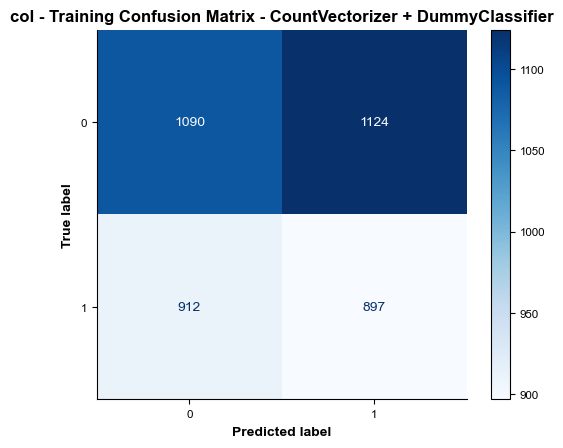

~~~~~~~~~~~~~~~~~~~~
Examining predictions for Competence
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: "Best Places To Work" by Built In Chicago
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: You make sure that you have enough candidates in the pipeline to ensure successful processes and you
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: With our solutions we inspire and enable our customers to create value from sustainability-related a
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: What your most excited for:
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: It is Alvarez & Marsal’s policy to provide and promote equal opportunity in employment, compensation
--------------------
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Work with the regional teams a

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.6s finished


Saving Learning Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Learning Curve - CountVectorizer + DummyClassifier.eps.


Saving Learning Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Learning Curve - CountVectorizer + DummyClassifier.png.
Saving Learning Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Learning Curve - CountVectorizer + DummyClassifier.svg.


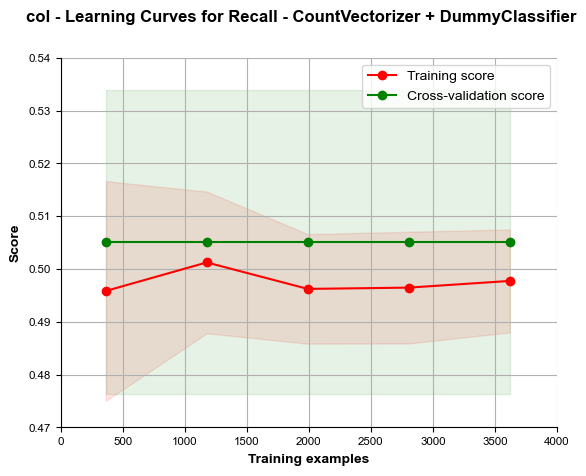

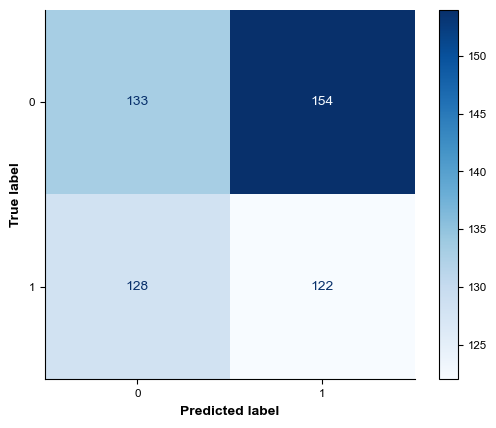

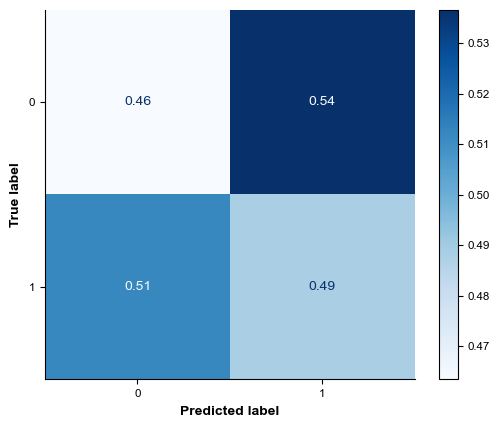

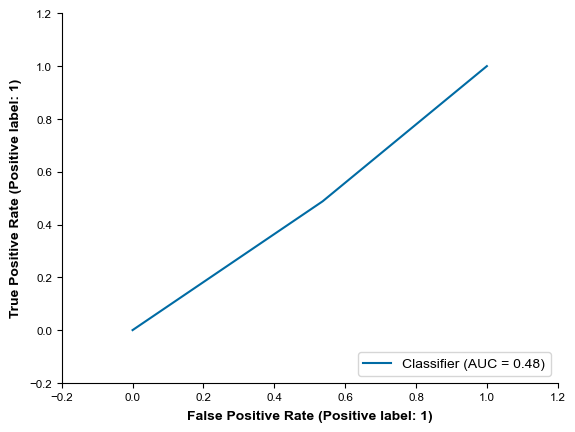

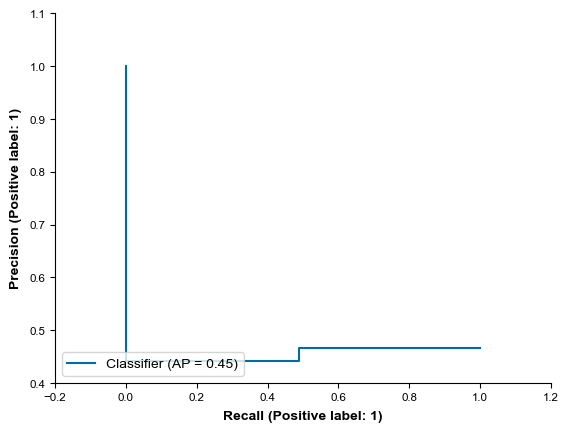

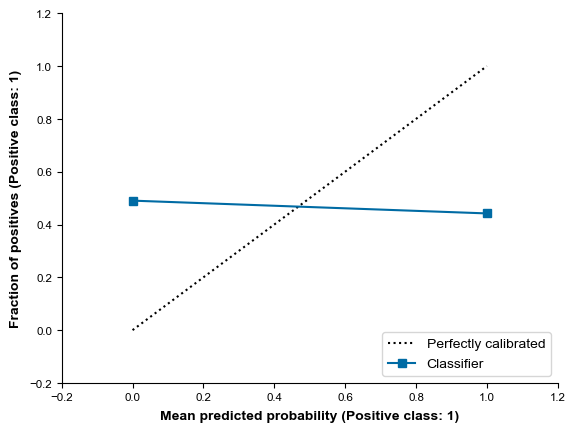

Plotting metrics with y_pred_prob:
Plotting Confusion Matrix:
Saving Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Confusion Matrix - CountVectorizer + DummyClassifier.eps
Saving Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Confusion Matrix - CountVectorizer + DummyClassifier.png
Saving Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Confusion Matrix - CountVectorizer + DummyClassifier.svg


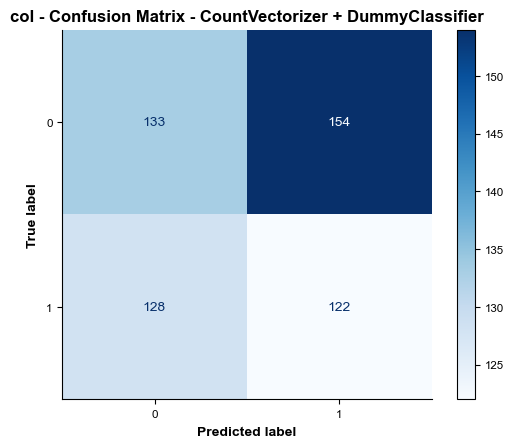

Saved Confusion Matrix!
Plotting Normalized Confusion Matrix:
Saving Normalized Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Normalized Confusion Matrix - CountVectorizer + DummyClassifier.eps
Saving Normalized Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Normalized Confusion Matrix - CountVectorizer + DummyClassifier.png
Saving Normalized Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Normalized Confusion Matrix - CountVectorizer + DummyClassifier.svg


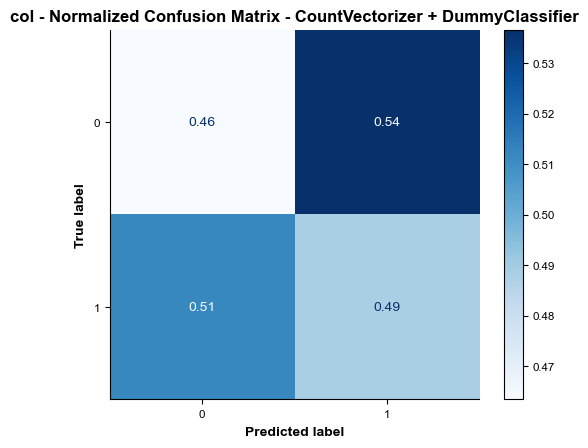

Saved Normalized Confusion Matrix!
Plotting ROC Curve:
Saving ROC Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - ROC Curve - CountVectorizer + DummyClassifier.eps


Saving ROC Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - ROC Curve - CountVectorizer + DummyClassifier.png
Saving ROC Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - ROC Curve - CountVectorizer + DummyClassifier.svg


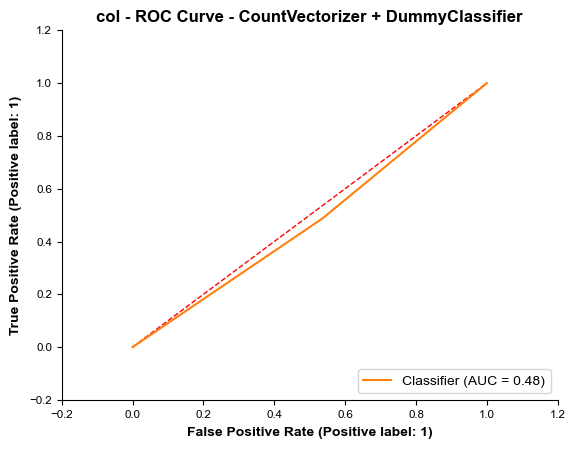

Saved ROC Curve!
Plotting Precision-Recall Curve:
Saving Precision-Recall Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Precision-Recall Curve - CountVectorizer + DummyClassifier.eps


Saving Precision-Recall Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Precision-Recall Curve - CountVectorizer + DummyClassifier.png
Saving Precision-Recall Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Precision-Recall Curve - CountVectorizer + DummyClassifier.svg


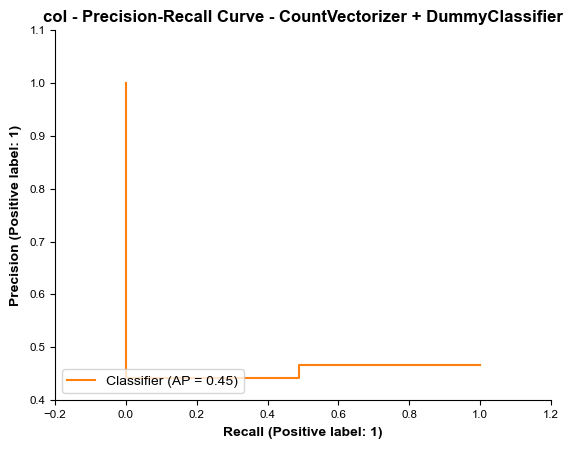

Saved Precision-Recall Curve!


Plotting Calibration Curve:
Saving Calibration Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Calibration Curve - CountVectorizer + DummyClassifier.eps
Saving Calibration Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Calibration Curve - CountVectorizer + DummyClassifier.png
Saving Calibration Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Calibration Curve - CountVectorizer + DummyClassifier.svg


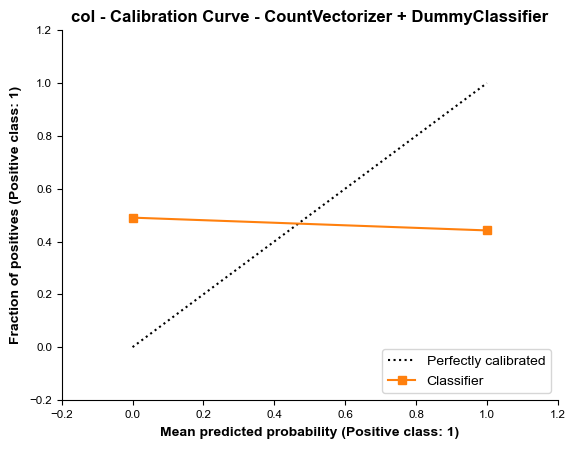

Saved Calibration Curve!
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.51      0.46      0.49       287
           1       0.44      0.49      0.46       250

    accuracy                           0.47       537
   macro avg       0.48      0.48      0.47       537
weighted avg       0.48      0.47      0.48       537

Saving plot_metric Curves at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - plot_metric Curves - CountVectorizer + DummyClassifier.eps


Saving plot_metric Curves at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - plot_metric Curves - CountVectorizer + DummyClassifier.png
Saving plot_metric Curves at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - plot_metric Curves - CountVectorizer + DummyClassifier.svg


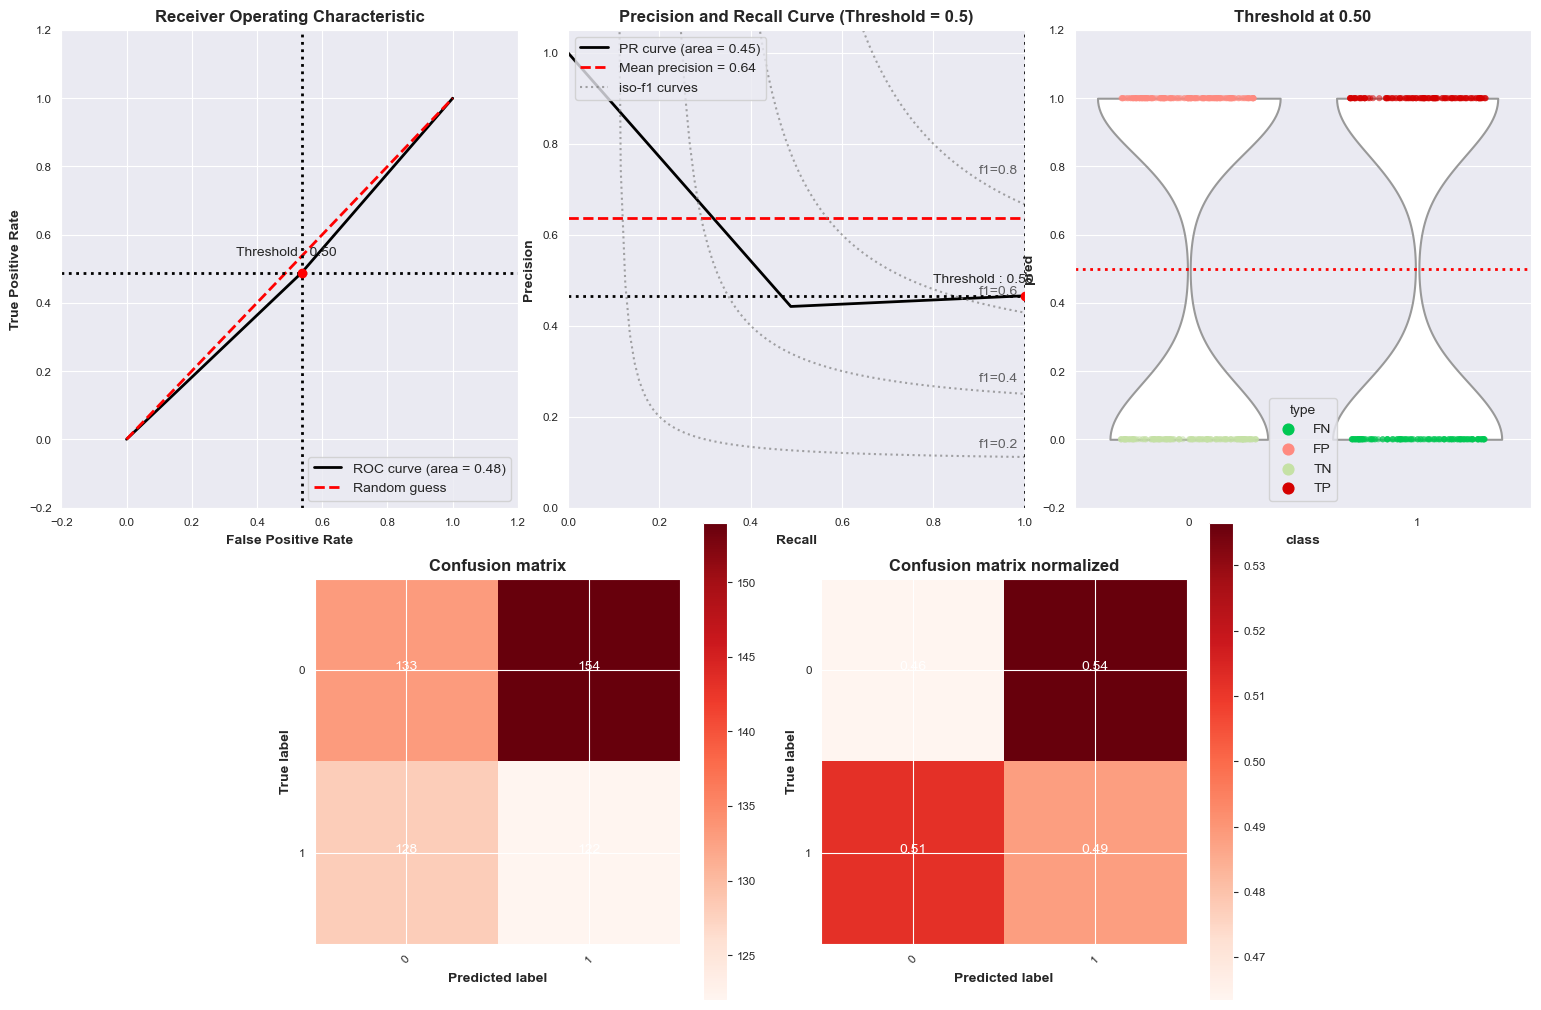

Plotting Heatmap:
Saving Heatmap at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Heatmap - CountVectorizer + DummyClassifier.eps
Saving Heatmap at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Heatmap - CountVectorizer + DummyClassifier.png
Saving Heatmap at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Heatmap - CountVectorizer + DummyClassifier.svg
Saved Heatmap!


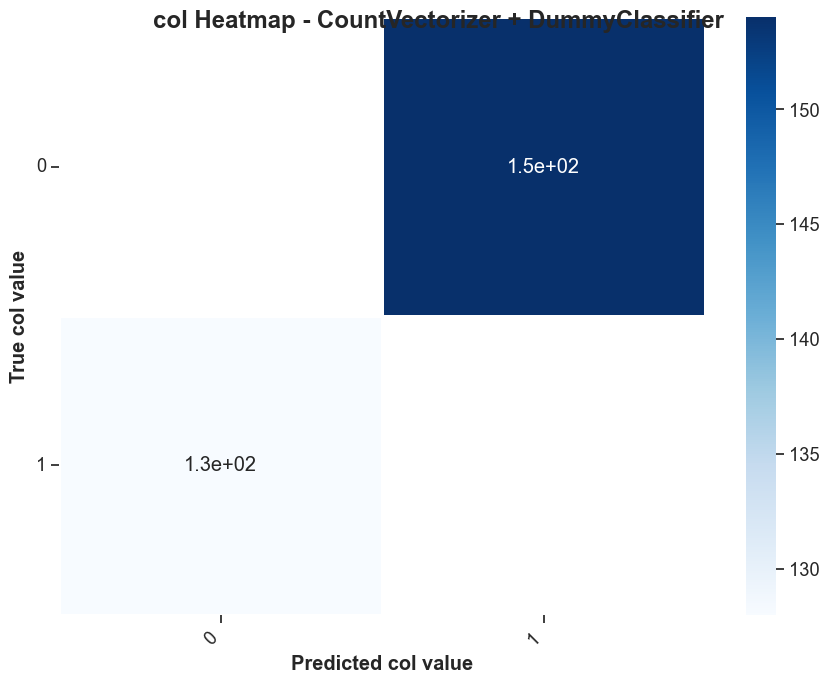

Saving fitted estimator and table at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/output tables/Supervised Estimators Table


/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_51136/207661405.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_metrics.to_latex(f'{save_path}.tex')
  2%|▎         | 1/40 [09:22<6:05:38, 562.53s/it]

Done saving fitted estimator and table!
Table does not exist, creating new table...
Done creating new table!
~~~~~~~~~~~~~~~~~~~~
Loading data for Warmth - CountVectorizer + KNeighborsClassifier
~~~~~~~~~~~~~~~~~~~~
Loading df_cv_results from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_cv_results - Warmth - CountVectorizer + KNeighborsClassifier (Save_protocol=5).pkl
Loading df_train_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_train_data - Warmth - CountVectorizer + KNeighborsClassifier (Save_protocol=5).pkl
Loading df_test_data from /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/classification models/Supervised Results/Search+Xy/Supervised df_test_data - Warmth - CountVectorizer + KNeighborsClassifier (Save_protocol=5).pkl
Loading df_val_dat

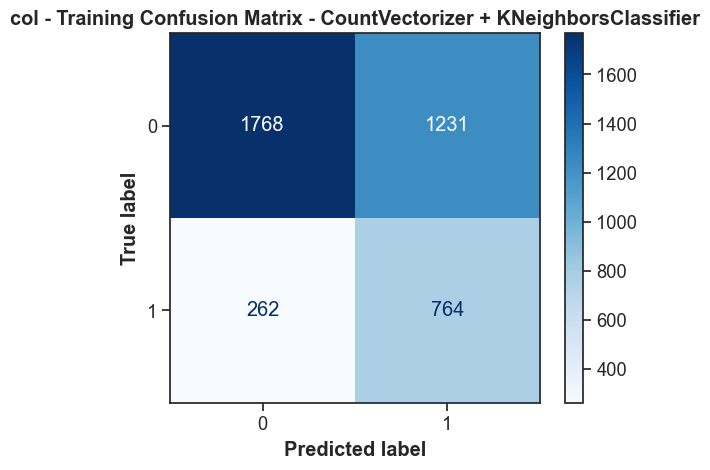

~~~~~~~~~~~~~~~~~~~~
Examining predictions for Warmth
Incorrectly Classified Reviews:
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: In the role of Application and Technical Support Manager - Bakery Key Accounts you’ll be at the hear
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: Single point of contact for all global communications of the two business units to strengthen Akzo
--------------------
--------------------
TRUE LABEL: 0
PREDICTED LABEL: 1
REVIEW TEXT: See specific task breakdown below, however the role will evolve over time based on needs, interests,
--------------------
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: As part of our culture we celebrate recognition and organize many social activities, such as our Ass
--------------------
--------------------
TRUE LABEL: 1
PREDICTED LABEL: 0
REVIEW TEXT: Highly collaborative teams that build relationships with world-class customers
--------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/homebrew/Caskroom/mambaforge/base/envs/study1_3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   42.0s finished


Saving Learning Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Learning Curve - CountVectorizer + KNeighborsClassifier.eps.
Saving Learning Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Learning Curve - CountVectorizer + KNeighborsClassifier.png.
Saving Learning Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Learning Curve - CountVectorizer + KNeighborsClassifier.svg.


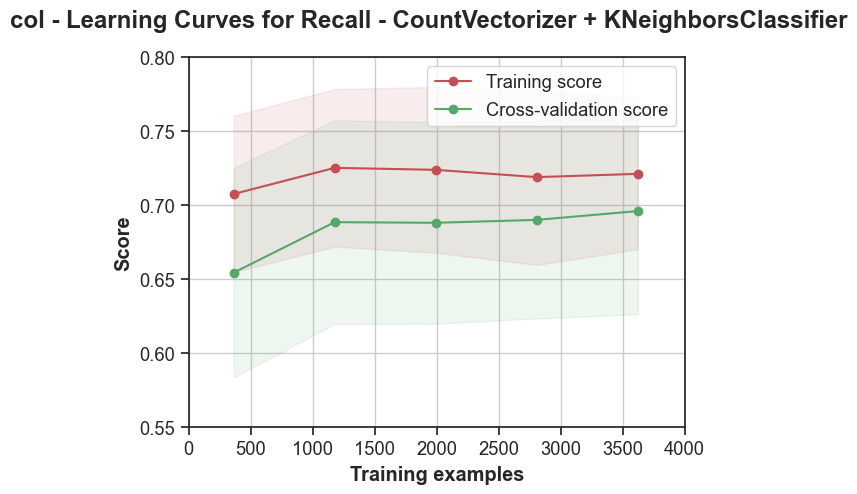

Plotting Validation Curve for N Neighbors.
--------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


Saving Validation Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Validation Curve for Recall - col - CountVectorizer + KNeighborsClassifier.eps


Saving Validation Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Validation Curve for Recall - col - CountVectorizer + KNeighborsClassifier.png
Saving Validation Curve at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Validation Curve for Recall - col - CountVectorizer + KNeighborsClassifier.svg


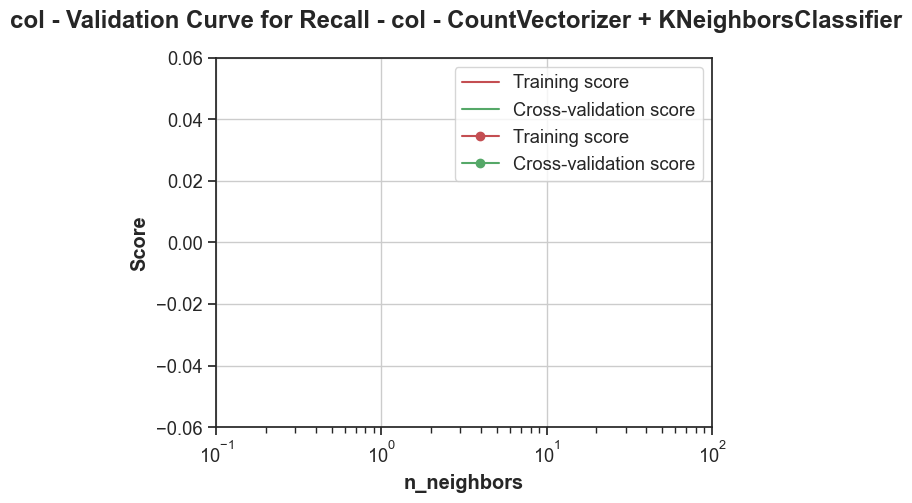

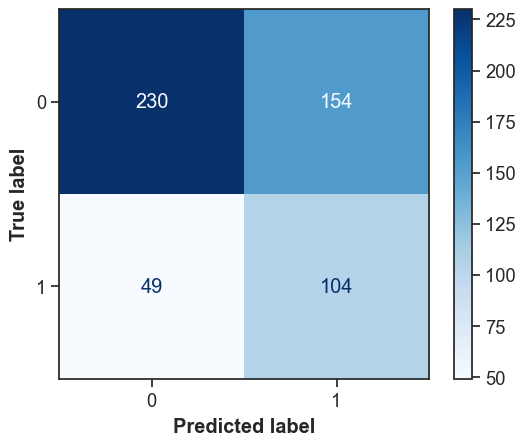

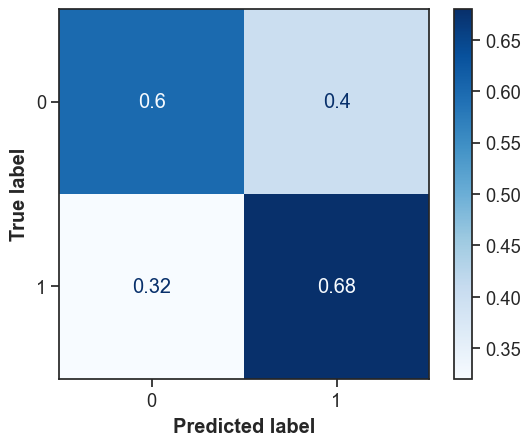

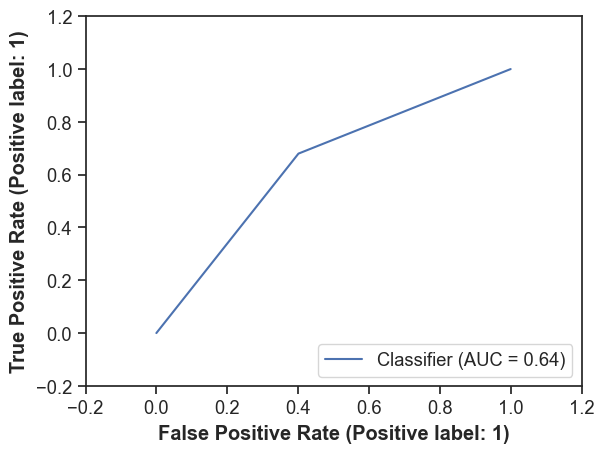

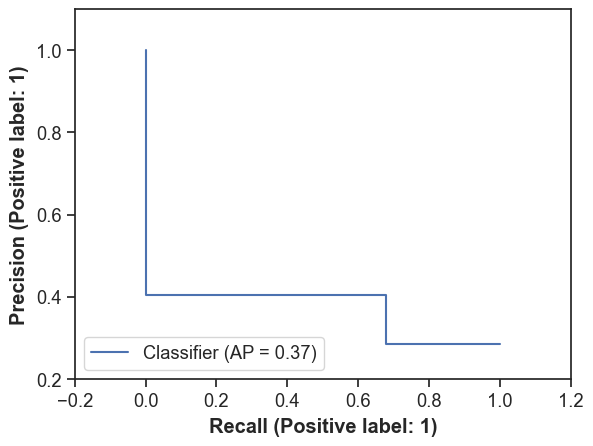

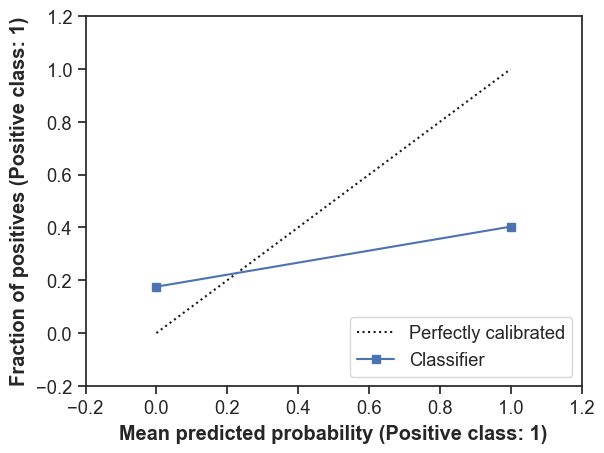

Plotting metrics with y_pred_prob:
Plotting Confusion Matrix:
Saving Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Confusion Matrix - CountVectorizer + KNeighborsClassifier.eps
Saving Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Confusion Matrix - CountVectorizer + KNeighborsClassifier.png
Saving Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Confusion Matrix - CountVectorizer + KNeighborsClassifier.svg


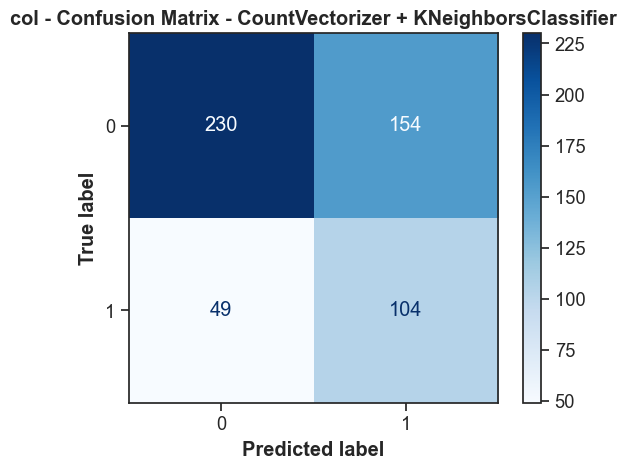

Saved Confusion Matrix!
Plotting Normalized Confusion Matrix:
Saving Normalized Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Normalized Confusion Matrix - CountVectorizer + KNeighborsClassifier.eps
Saving Normalized Confusion Matrix at /Users/nyxinsane/Documents/Work - UvA/Automating Equity/Study 1/Study1_Code/data/plots/Supervised col - Normalized Confusion Matrix - CountVectorizer + KNeighborsClassifier.png


In [46]:
%%time
print('#'*40)
print('Starting!')
print('#'*40)

method = 'Supervised'
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

# Get existing estimators
col_names_list, vectorizer_names_list, classifier_names_list, estimator_names_list = get_existing_files()

# Identify cols, vectorizers and classifiers
for estimators_file in tqdm.tqdm(glob.glob(f'{results_save_path}*.pkl')):
    if ' Estimator - ' in estimators_file:
        col = estimators_file.split(f'{method} Estimator - ')[-1].split(' - ')[0]
        vectorizer_name = estimators_file.split(f'{col} - ')[-1].split(' + ')[0]
        classifier_name = estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[0]
        protocol = int(estimators_file.split(f'{vectorizer_name} + ')[-1].split(' (Save_protocol=')[-1].split(').pkl')[0])
        # Load Table DF
        df_metrics = make_df_metrics(
            vectorizers_pipe=vectorizers_pipe, classifiers_pipe=classifiers_pipe, metrics_list=list(metrics_dict.keys()),
            col=col, vectorizer_name=vectorizer_name, classifier_name=classifier_name, protocol=protocol
        )

        print('~'*20)
        print(f'Loading data for {col} - {vectorizer_name} + {classifier_name}')
        print('~'*20)
        # Load X, y, search_cv, estimator
        (
            # HACK
            # grid_search, searchcv,
            X_train, y_train, y_train_pred,
            X_test, y_test, y_test_pred, y_test_pred_prob,
            df_feature_importances, estimator,
        ) = load_Xy_search_cv_estimator(
            col, vectorizer_name, classifier_name, protocol
        )

        print('-'*20)
        print(f'{"="*30} EVALUATING DATASET OF LENGTH {len(X_train)+len(X_test)} ON {col.upper()} {"="*30}')
        print('-'*20)

        # Identify and name steps in estimator
        vectorizer = estimator[0]
        vectorizer_params = vectorizer.get_params()
        vectorizer_name = vectorizer.__class__.__name__
        selector = estimator[1]
        selector_params = selector.get_params()
        selector_name = selector.__class__.__name__
        classifier = estimator[-1]
        classifier_params = classifier.get_params()
        classifier_name = classifier.__class__.__name__
        if col == 'Warmth':
            resampler = estimator[-2]
            resampler_params = resampler.get_params()
            resampler_name = resampler.__class__.__name__

        # Print results
        print('='*20)
        print(
        #     f'GridSearch - Best mean train score: M = {float(best_mean_train_score:=searchcv.cv_results_["mean_train_score"][best_index:=searchcv.best_index_]):.2f}, SD = {int(best_std_train_score:=searchcv.cv_results_["std_train_score"][best_index]):.2f}\n'
        # )
        # print(
        #     f'GridSearch - Best mean test score: M = {float(best_mean_test_score:=searchcv.cv_results_["mean_test_score"][best_index]):.2f}, SD = {int(best_std_test_score:=searchcv.cv_results_["std_test_score"][best_index]):.2f}\n'
        # )
        # print(
        #     f'Number of splits: {int(n_splits:=searchcv.n_splits_)}\n'
        # )
        # print(
        #     f'Best estimator and parameters:\n{estimator}\n')
        # print(
        #     f'Best parameters:\n{(best_params:=searchcv.best_params_)}\n'
        )
        print(
            f'Training Classification Report:\n{(train_report:=metrics.classification_report(y_train, y_train_pred, labels=np.unique(y_train_pred), zero_division=0))}\n'
        )
        print(
        #     f'Best train score: {float(best_train_score:=searchcv.best_score_):.2f}\n'
        # )
        # print(
        #     f'Best test score: {float(best_test_score:=searchcv.score(X_test, y_test)):.2f}\n'
        )
        print('='*20)
        print('Training Confusion Matrix:\n')
        close_plots()
        fig, ax = plt.subplots()
        ax.set_title(
            f'col - Training Confusion Matrix - {vectorizer_name} + {classifier_name}')
        train_cm = metrics.ConfusionMatrixDisplay.from_estimator(
            estimator, X_train, y_train, ax=ax, cmap=plt.cm.Blues
        )
        show_and_close_plots()
        print('='*20)

        # Examine predictions
        examine_predictions(
            X_test, y_test, y_test_pred, col
        )

        # Evaluate Model
        df_metrics, metrics_dict, df_cv_score_recall = evaluation(
            estimator, X_test, y_test, y_test_pred, y_test_pred_prob,
            # HACK
            # best_train_score, 
            df_metrics,
            col, vectorizer_name, classifier_name, 
        )

        # Save Vectorizer, Selector, and Classifier
        save_table(df_metrics, col, vectorizer_name, classifier_name)

# Compare Estimators
print('='*20)
print(f'Comparing Estimators for {col}')
comparison_plots(get_completed_estimators(), X_test, y_test, col)
print('='*20)

print('#'*40)
print('DONE!')
print('#'*40)
